# Regression Model with Seasonal ARIMA

- **Regression Goal**: Build a regression model to predict the hourly value of the PT08_S4_NO2 variable [3]
- ARIMA = Autoregressive Integrated Moving Average. More details in [6]
- (Seasonal) ARIMA errors ie: the (S)ARIMAX can be visualized and decomposted in [3]
- Since we are using (S)ARIMAX, we may also implicitly use past values of the dependent variable PT08_S4_NO2 and past errors of the model as additional regression variables [3]
- **Regression Strategy**: The variables are [3]
    - X $ -- $ a matrix (of two independent variables (IV): (1) Temperature (T) and (2) Absolute Humidity (AH))
    - y $ -- $ a vector (of one dependent variable (DV): (PT08_S4_NO2))
    - columns in data wrt variables $ -- $ T, AH, PT08_S4_NO2
    - SIDE NOTE: (IV) vs (DV): (IV) causes the effect on the (DV) and (DV) depends on (IV). See User Studies in [4]

# Imports + Load Data

In [1]:
# !pip install statsmodels

In [2]:
import numpy as np
import pandas as pd
import statsmodels.api as statsmodel
import statsmodels.regression as regression
import patsy as patsy
import statsmodels.graphics.tsaplots as tsa
from matplotlib import pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA as ARIMA

from sklearn.model_selection import train_test_split

In [3]:
BASE = '/Users/brinkley97/Documents/development/'
DATASET_PATH = 'book-forecasting_and_control_by_4_Gs/datasets/'
FILE = 'air_quality_uci_mod.csv'
file_path = BASE + DATASET_PATH + FILE
air_quality_df = pd.read_csv(file_path, header=0)
air_quality_df

,DateTime,CO_GT,PT08_S1_CO,NMHC_GT,C6H6_GT,PT08_S2_NMHC,NOx_GT,PT08_S3_NOx,NO2_GT,PT08_S4_NO2,PT08_S5_O3,T,RH,AH
0,03-10-04 18:00,2.6,1360,150,11.9,1046,166,1056,113,1692,1268,13.6,48.9,0.7578
1,03-10-04 19:00,2.0,1292,112,9.4,955,103,1174,92,1559,972,13.3,47.7,0.7255
2,03-10-04 20:00,2.2,1402,88,9.0,939,131,1140,114,1555,1074,11.9,54.0,0.7502
3,03-10-04 21:00,2.2,1376,80,9.2,948,172,1092,122,1584,1203,11.0,60.0,0.7867
4,03-10-04 22:00,1.6,1272,51,6.5,836,131,1205,116,1490,1110,11.2,59.6,0.7888
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7339,04-04-05 10:00,3.1,1314,-200,13.5,1101,472,539,190,1374,1729,21.9,29.3,0.7568
7340,04-04-05 11:00,2.4,1163,-200,11.4,1027,353,604,179,1264,1269,24.3,23.7,0.7119
7341,04-04-05 12:00,2.4,1142,-200,12.4,1063,293,603,175,1241,1092,26.9,18.3,0.6406
7342,04-04-05 13:00,2.1,1003,-200,9.5,961,235,702,156,1041,770,28.3,13.5,0.5139


# 1. Prepare the Data

`1.1. Convert the dateTime column to a pandas DateTime column and set it as the index of the DataFrame. Learn more at [7][8].`

In [4]:
air_quality_df['DateTimeIndex'] = pd.to_datetime(air_quality_df.loc[0:, 'DateTime'])
air_quality_df

,DateTime,CO_GT,PT08_S1_CO,NMHC_GT,C6H6_GT,PT08_S2_NMHC,NOx_GT,PT08_S3_NOx,NO2_GT,PT08_S4_NO2,PT08_S5_O3,T,RH,AH,DateTimeIndex
0,03-10-04 18:00,2.6,1360,150,11.9,1046,166,1056,113,1692,1268,13.6,48.9,0.7578,2004-03-10 18:00:00
1,03-10-04 19:00,2.0,1292,112,9.4,955,103,1174,92,1559,972,13.3,47.7,0.7255,2004-03-10 19:00:00
2,03-10-04 20:00,2.2,1402,88,9.0,939,131,1140,114,1555,1074,11.9,54.0,0.7502,2004-03-10 20:00:00
3,03-10-04 21:00,2.2,1376,80,9.2,948,172,1092,122,1584,1203,11.0,60.0,0.7867,2004-03-10 21:00:00
4,03-10-04 22:00,1.6,1272,51,6.5,836,131,1205,116,1490,1110,11.2,59.6,0.7888,2004-03-10 22:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7339,04-04-05 10:00,3.1,1314,-200,13.5,1101,472,539,190,1374,1729,21.9,29.3,0.7568,2005-04-04 10:00:00
7340,04-04-05 11:00,2.4,1163,-200,11.4,1027,353,604,179,1264,1269,24.3,23.7,0.7119,2005-04-04 11:00:00
7341,04-04-05 12:00,2.4,1142,-200,12.4,1063,293,603,175,1241,1092,26.9,18.3,0.6406,2005-04-04 12:00:00
7342,04-04-05 13:00,2.1,1003,-200,9.5,961,235,702,156,1041,770,28.3,13.5,0.5139,2005-04-04 13:00:00


In [5]:
# air_quality_df["DateTime"]
air_quality_df.drop(columns=["DateTime"], inplace=True)
air_quality_df

,CO_GT,PT08_S1_CO,NMHC_GT,C6H6_GT,PT08_S2_NMHC,NOx_GT,PT08_S3_NOx,NO2_GT,PT08_S4_NO2,PT08_S5_O3,T,RH,AH,DateTimeIndex
0,2.6,1360,150,11.9,1046,166,1056,113,1692,1268,13.6,48.9,0.7578,2004-03-10 18:00:00
1,2.0,1292,112,9.4,955,103,1174,92,1559,972,13.3,47.7,0.7255,2004-03-10 19:00:00
2,2.2,1402,88,9.0,939,131,1140,114,1555,1074,11.9,54.0,0.7502,2004-03-10 20:00:00
3,2.2,1376,80,9.2,948,172,1092,122,1584,1203,11.0,60.0,0.7867,2004-03-10 21:00:00
4,1.6,1272,51,6.5,836,131,1205,116,1490,1110,11.2,59.6,0.7888,2004-03-10 22:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7339,3.1,1314,-200,13.5,1101,472,539,190,1374,1729,21.9,29.3,0.7568,2005-04-04 10:00:00
7340,2.4,1163,-200,11.4,1027,353,604,179,1264,1269,24.3,23.7,0.7119,2005-04-04 11:00:00
7341,2.4,1142,-200,12.4,1063,293,603,175,1241,1092,26.9,18.3,0.6406,2005-04-04 12:00:00
7342,2.1,1003,-200,9.5,961,235,702,156,1041,770,28.3,13.5,0.5139,2005-04-04 13:00:00


In [6]:
air_quality_df.set_index(['DateTimeIndex'])

,CO_GT,PT08_S1_CO,NMHC_GT,C6H6_GT,PT08_S2_NMHC,NOx_GT,PT08_S3_NOx,NO2_GT,PT08_S4_NO2,PT08_S5_O3,T,RH,AH
DateTimeIndex,,,,,,,,,,,,,
2004-03-10 18:00:00,2.6,1360,150,11.9,1046,166,1056,113,1692,1268,13.6,48.9,0.7578
2004-03-10 19:00:00,2.0,1292,112,9.4,955,103,1174,92,1559,972,13.3,47.7,0.7255
2004-03-10 20:00:00,2.2,1402,88,9.0,939,131,1140,114,1555,1074,11.9,54.0,0.7502
2004-03-10 21:00:00,2.2,1376,80,9.2,948,172,1092,122,1584,1203,11.0,60.0,0.7867
2004-03-10 22:00:00,1.6,1272,51,6.5,836,131,1205,116,1490,1110,11.2,59.6,0.7888
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2005-04-04 10:00:00,3.1,1314,-200,13.5,1101,472,539,190,1374,1729,21.9,29.3,0.7568
2005-04-04 11:00:00,2.4,1163,-200,11.4,1027,353,604,179,1264,1269,24.3,23.7,0.7119
2005-04-04 12:00:00,2.4,1142,-200,12.4,1063,293,603,175,1241,1092,26.9,18.3,0.6406


In [7]:
# new index is NOT set; test with uncommenting next line
# air_quality_df

In [8]:
air_quality_df.set_index(['DateTimeIndex'], inplace=True)

In [9]:
# new index is set
air_quality_df

,CO_GT,PT08_S1_CO,NMHC_GT,C6H6_GT,PT08_S2_NMHC,NOx_GT,PT08_S3_NOx,NO2_GT,PT08_S4_NO2,PT08_S5_O3,T,RH,AH
DateTimeIndex,,,,,,,,,,,,,
2004-03-10 18:00:00,2.6,1360,150,11.9,1046,166,1056,113,1692,1268,13.6,48.9,0.7578
2004-03-10 19:00:00,2.0,1292,112,9.4,955,103,1174,92,1559,972,13.3,47.7,0.7255
2004-03-10 20:00:00,2.2,1402,88,9.0,939,131,1140,114,1555,1074,11.9,54.0,0.7502
2004-03-10 21:00:00,2.2,1376,80,9.2,948,172,1092,122,1584,1203,11.0,60.0,0.7867
2004-03-10 22:00:00,1.6,1272,51,6.5,836,131,1205,116,1490,1110,11.2,59.6,0.7888
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2005-04-04 10:00:00,3.1,1314,-200,13.5,1101,472,539,190,1374,1729,21.9,29.3,0.7568
2005-04-04 11:00:00,2.4,1163,-200,11.4,1027,353,604,179,1264,1269,24.3,23.7,0.7119
2005-04-04 12:00:00,2.4,1142,-200,12.4,1063,293,603,175,1241,1092,26.9,18.3,0.6406


`1.2. Set DF to an Hourly Frequency - 1.3 Verify No Empty Cells`

- The reasoning is because we want to make predictions at new hours.
- Doing this will create empty rows as there may NOT be a hourly measurement at that time in the original data. An [ex](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.asfreq.html) with upsampling the time from minute $ \rightarrow $ seconds by Pandas
- Fill empty (nan) cells with the mean of the corresponding column. Read on upsampling in my notes [12].  
- Convert time series to specified frequency with [df]`.asfreq()` in pandas
- Note the #rows will increase

In [10]:
air_quality_df = air_quality_df.asfreq('H')
air_quality_df

,CO_GT,PT08_S1_CO,NMHC_GT,C6H6_GT,PT08_S2_NMHC,NOx_GT,PT08_S3_NOx,NO2_GT,PT08_S4_NO2,PT08_S5_O3,T,RH,AH
DateTimeIndex,,,,,,,,,,,,,
2004-03-10 18:00:00,2.6,1360.0,150.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578
2004-03-10 19:00:00,2.0,1292.0,112.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255
2004-03-10 20:00:00,2.2,1402.0,88.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502
2004-03-10 21:00:00,2.2,1376.0,80.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867
2004-03-10 22:00:00,1.6,1272.0,51.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2005-04-04 10:00:00,3.1,1314.0,-200.0,13.5,1101.0,472.0,539.0,190.0,1374.0,1729.0,21.9,29.3,0.7568
2005-04-04 11:00:00,2.4,1163.0,-200.0,11.4,1027.0,353.0,604.0,179.0,1264.0,1269.0,24.3,23.7,0.7119
2005-04-04 12:00:00,2.4,1142.0,-200.0,12.4,1063.0,293.0,603.0,175.0,1241.0,1092.0,26.9,18.3,0.6406


In [11]:
air_quality_df = air_quality_df.fillna(air_quality_df.mean())
air_quality_df

,CO_GT,PT08_S1_CO,NMHC_GT,C6H6_GT,PT08_S2_NMHC,NOx_GT,PT08_S3_NOx,NO2_GT,PT08_S4_NO2,PT08_S5_O3,T,RH,AH
DateTimeIndex,,,,,,,,,,,,,
2004-03-10 18:00:00,2.6,1360.0,150.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578
2004-03-10 19:00:00,2.0,1292.0,112.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255
2004-03-10 20:00:00,2.2,1402.0,88.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502
2004-03-10 21:00:00,2.2,1376.0,80.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867
2004-03-10 22:00:00,1.6,1272.0,51.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2005-04-04 10:00:00,3.1,1314.0,-200.0,13.5,1101.0,472.0,539.0,190.0,1374.0,1729.0,21.9,29.3,0.7568
2005-04-04 11:00:00,2.4,1163.0,-200.0,11.4,1027.0,353.0,604.0,179.0,1264.0,1269.0,24.3,23.7,0.7119
2005-04-04 12:00:00,2.4,1142.0,-200.0,12.4,1063.0,293.0,603.0,175.0,1241.0,1092.0,26.9,18.3,0.6406


In [12]:
# should be all 0s
air_quality_df.isin([np.nan, np.inf, -np.inf]).sum()

CO_GT           0
PT08_S1_CO      0
NMHC_GT         0
C6H6_GT         0
PT08_S2_NMHC    0
NOx_GT          0
PT08_S3_NOx     0
NO2_GT          0
PT08_S4_NO2     0
PT08_S5_O3      0
T               0
RH              0
AH              0
dtype: int64

`1.4.1. Split Data`

- Train (90%) and Test (10%)

In [13]:
dataset_len = len(air_quality_df)
print(dataset_len)
split_data = round(dataset_len*0.9)
print(split_data)
train_set_end_date = air_quality_df.index[split_data]
print(train_set_end_date)
df_train = air_quality_df.loc[air_quality_df.index <= train_set_end_date].copy()
print("Train:", np.shape(df_train))
df_test = air_quality_df.loc[air_quality_df.index > train_set_end_date].copy()
print("Test:", np.shape(df_test))

9357
8421
2005-02-24 15:00:00
Train: (8422, 13)
Test: (935, 13)


In [14]:
# train_test_data = [air_quality_df, dataset_len, split_data, train_set_end_date, df_train, df_test]

`1.4.2. Using sklearn train_test_split; NOT exactly matching yet`

In [15]:
# air_quality_df

In [16]:
temperature_series = air_quality_df['T']
# temperature_series

In [17]:
ah_series = air_quality_df['AH']
# ah_series

In [18]:
X_df = pd.concat([temperature_series, ah_series], axis=1)
# X_df

In [19]:
X = np.array(X_df)
# X, np.shape(X)

In [20]:
y_series = air_quality_df['PT08_S4_NO2']
# y_series

In [21]:
y = np.array(y_series)
# y, np.shape(y)

In [22]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.9, random_state=42)

In [23]:
# print("[INFO] X, y TRAIN sets")
# print(np.shape(X_train), np.shape(y_train))
    
# print("\n[INFO] X, y TEST sets")
# print(np.shape(X_test), np.shape(y_test))

# 2. Create a Linear Regression model

2.1. Create model expression with the [Patsy](https://patsy.readthedocs.io/en/latest/quickstart.html) syntax

In [24]:
# variable = DV (vector y) ~ IV (vector x) + IV (vector x) (so both IV -> Matrix X); find the coef, std err, t, and P>|t|, respectively
expr = 'PT08_S4_NO2 ~ T + AH'

2.2. Carve out the y vector (true labels) and X matrix (input features) with the [Patsy](https://patsy.readthedocs.io/en/latest/quickstart.html) `dmatrices` syntax

In [25]:
y_train, X_train = patsy.dmatrices(expr, df_train, return_type='dataframe')
# y_train

In [26]:
# X_train

In [27]:
y_test, X_test = patsy.dmatrices(expr, df_test, return_type='dataframe')
# y_test

In [28]:
# X_test

2.3. Fit an Ordinary Least Squares Linear Regression (OLSR) model on the training dataset and 2.4. Show results and see explanations in [3]

- OLSR is a common technique for estimating the coefficients of linear regression equations. These coefficients are...
- OLSR describes the relationship between one or more IV and a DV
- Formulation with more notes [9] and code from scratch [10] (which code isn't matching results below)

In [29]:
# initialize with the OLS estimator
olsr_estimator = regression.linear_model.OLS(y_train, X_train)
# olsr_estimator

In [30]:
# 'fit' method trains the algorithm on the training data, after the model is initialized
olsr_train = olsr_estimator.fit()
# olsr_train

In [31]:
olsr_results = olsr_train.summary()
olsr_results

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            PT08_S4_NO2   R-squared:                       0.415
Model:                            OLS   Adj. R-squared:                  0.415
Method:                 Least Squares   F-statistic:                     2991.
Date:                Fri, 14 Apr 2023   Prob (F-statistic):               0.00
Time:                        22:49:07   Log-Likelihood:                -57736.
No. Observations:                8422   AIC:                         1.155e+05
Df Residuals:                    8419   BIC:                         1.155e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    902.9774      7.820    115.471      0.000     887.648     918.306
T              9.7918      0.423     23.138      0.000       8.962      10.621
AH           384.4853      9.407     40.873      0.000     366.046     402.925
==============================================================================
Omnibus:                     1713.095   Durbin-Watson:                   0.343
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4031.921
Skew:                           1.142   Prob(JB):                         0.00
Kurtosis:                       5.504   Cond. No.                         87.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

- See P>|t| as it's the p-value. We can say that X matrix (composed of T vector and AH vector) is significant at a 99.99% confidence level
- The Durbin-Watson test measures the degree of LAG-1 auto-correlation in the residual errors of regression. See more about lags in [11]. 0.348 indicating a strong positive auto-correlation among the residual errors of regression at LAG-1.

In [32]:
# olsr_results.params
print(olsr_train.params)

print()

# Regression errors
regression_errors = olsr_train.resid
print(type(regression_errors), regression_errors)

Intercept    902.977354
T              9.791778
AH           384.485262
dtype: float64

<class 'pandas.core.series.Series'> DateTimeIndex
2004-03-10 18:00:00    364.491532
2004-03-10 19:00:00    246.847939
2004-03-10 20:00:00    247.059642
2004-03-10 21:00:00    270.838531
2004-03-10 22:00:00    174.072756
                          ...    
2005-02-24 11:00:00    -75.043871
2005-02-24 12:00:00   -118.122566
2005-02-24 13:00:00    -51.676736
2005-02-24 14:00:00    -41.620804
2005-02-24 15:00:00     28.773269
Length: 8422, dtype: float64


# 3. Estimate (S)ARIMA parameters (p, d, q), (P, D, Q), and m

`Plot the Auto-correlation (ACF/ACor) of the residual errors. Summarize ACF plots`
- `alpha`: The confidence intervals; the lower, the thicker the blue highlight on the x-axis (0 - 40), y-axis (0.00)

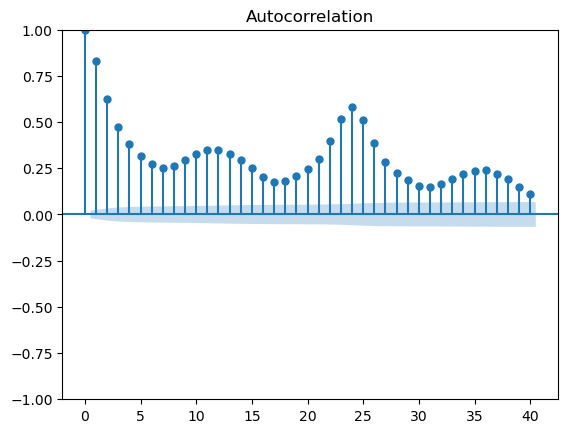

In [33]:
tsa.plot_acf(regression_errors, alpha=0.05)
plt.show()

`Difference the time series once (i.e: d = 1) and compare with non-difference ts`

In [34]:
olsr_residuals_diff_by_1 = olsr_train.resid.diff()
olsr_residuals_diff_by_1

DateTimeIndex
2004-03-10 18:00:00           NaN
2004-03-10 19:00:00   -117.643593
2004-03-10 20:00:00      0.211703
2004-03-10 21:00:00     23.778888
2004-03-10 22:00:00    -96.765775
                          ...    
2005-02-24 11:00:00    -92.049345
2005-02-24 12:00:00    -43.078695
2005-02-24 13:00:00     66.445830
2005-02-24 14:00:00     10.055932
2005-02-24 15:00:00     70.394073
Length: 8422, dtype: float64

In [35]:
no_diff_vs_diff_by_1_df = pd.concat([regression_errors, olsr_residuals_diff_by_1], axis=1)
no_diff_vs_diff_by_1_df

,0,1
DateTimeIndex,,
2004-03-10 18:00:00,364.491532,NaN
2004-03-10 19:00:00,246.847939,-117.643593
2004-03-10 20:00:00,247.059642,0.211703
2004-03-10 21:00:00,270.838531,23.778888
2004-03-10 22:00:00,174.072756,-96.765775
...,...,...
2005-02-24 11:00:00,-75.043871,-92.049345
2005-02-24 12:00:00,-118.122566,-43.078695
2005-02-24 13:00:00,-51.676736,66.445830


In [36]:
olsr_residuals_diff_by_1 = olsr_residuals_diff_by_1.dropna()
olsr_residuals_diff_by_1

DateTimeIndex
2004-03-10 19:00:00   -117.643593
2004-03-10 20:00:00      0.211703
2004-03-10 21:00:00     23.778888
2004-03-10 22:00:00    -96.765775
2004-03-10 23:00:00    -95.462059
                          ...    
2005-02-24 11:00:00    -92.049345
2005-02-24 12:00:00    -43.078695
2005-02-24 13:00:00     66.445830
2005-02-24 14:00:00     10.055932
2005-02-24 15:00:00     70.394073
Length: 8421, dtype: float64

`Replot the ACF of the 1 differenced time series of residual errors`
- notice `alpha`

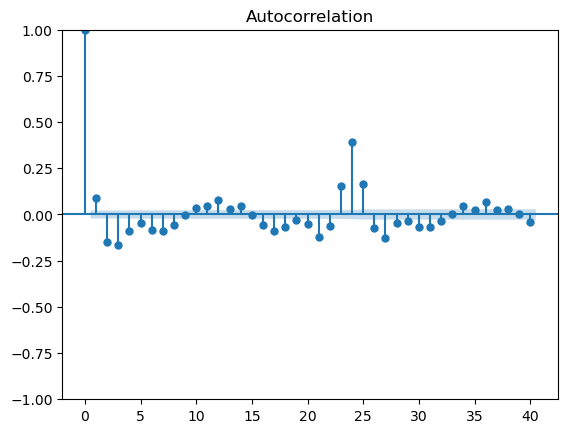

In [37]:
tsa.plot_acf(olsr_residuals_diff_by_1, alpha=0.05)
plt.show()

`Difference the time series again (i.e.: d = 2) and compare with non-difference ts and differenced 1 ts`

In [38]:
olsr_residuals_diff_by_2 = olsr_residuals_diff_by_1.diff()
olsr_residuals_diff_by_2

DateTimeIndex
2004-03-10 19:00:00           NaN
2004-03-10 20:00:00    117.855296
2004-03-10 21:00:00     23.567185
2004-03-10 22:00:00   -120.544663
2004-03-10 23:00:00      1.303716
                          ...    
2005-02-24 11:00:00    125.522834
2005-02-24 12:00:00     48.970650
2005-02-24 13:00:00    109.524526
2005-02-24 14:00:00    -56.389898
2005-02-24 15:00:00     60.338141
Length: 8421, dtype: float64

In [39]:
olsr_residuals_diff_by_1_and_2 = pd.concat([no_diff_vs_diff_by_1_df, olsr_residuals_diff_by_2], axis=1)
olsr_residuals_diff_by_1_and_2

,0,1,0
DateTimeIndex,,,
2004-03-10 18:00:00,364.491532,NaN,NaN
2004-03-10 19:00:00,246.847939,-117.643593,NaN
2004-03-10 20:00:00,247.059642,0.211703,117.855296
2004-03-10 21:00:00,270.838531,23.778888,23.567185
2004-03-10 22:00:00,174.072756,-96.765775,-120.544663
...,...,...,...
2005-02-24 11:00:00,-75.043871,-92.049345,125.522834
2005-02-24 12:00:00,-118.122566,-43.078695,48.970650
2005-02-24 13:00:00,-51.676736,66.445830,109.524526


In [40]:
olsr_residuals_diff_by_2 = olsr_residuals_diff_by_2.dropna()

`Replot the ACF of the 2 differenced time series of residual errors`

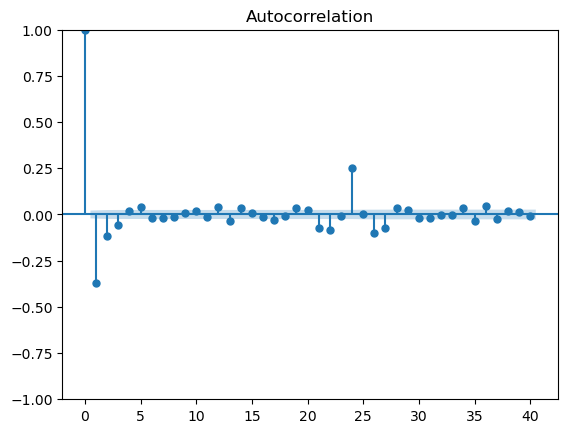

In [41]:
tsa.plot_acf(olsr_residuals_diff_by_2, alpha=0.05)
plt.show()

`Verify that the seasonal period is 24 wrt the non-differenced ts of regression errors (d = 0)`

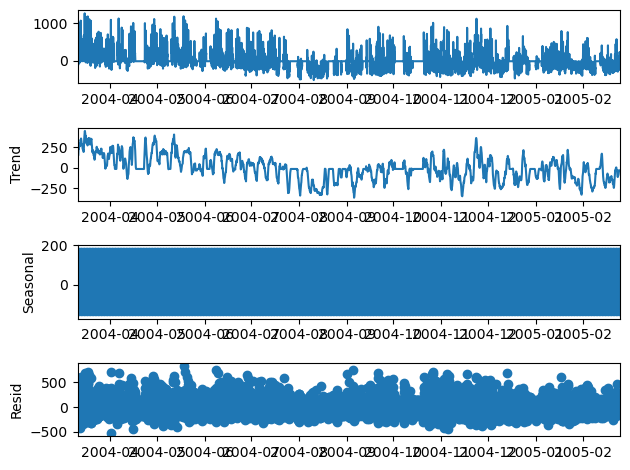

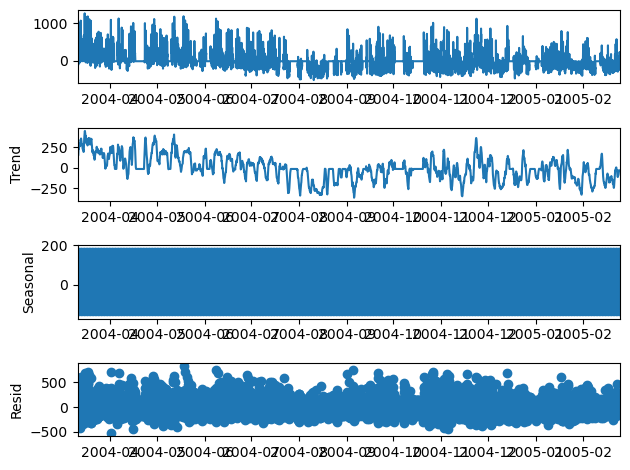

In [42]:
components = seasonal_decompose(regression_errors)
components.plot()

`Verify that the seasonal period is 24 wrt the differenced ts of residual errors (d = 1)`

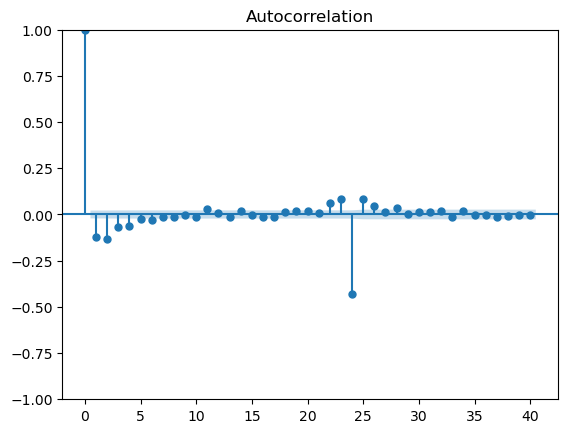

In [43]:
olsr_resid_diff_1_24 = olsr_residuals_diff_by_1.diff(periods=24)
olsr_resid_diff_1_24 = olsr_resid_diff_1_24.dropna()
tsa.plot_acf(olsr_resid_diff_1_24, alpha=0.05)
plt.show()

# 4. Build and fit the Regression Model with Seasonal ARIMA errors

`Fit the SARIMAX model on the training data set (y_train, X_train)`

In [44]:
# X_train

In [45]:
X_train_minus_intercept = X_train.drop('Intercept', axis=1)
X_train_minus_intercept

,T,AH
DateTimeIndex,,
2004-03-10 18:00:00,13.6,0.7578
2004-03-10 19:00:00,13.3,0.7255
2004-03-10 20:00:00,11.9,0.7502
2004-03-10 21:00:00,11.0,0.7867
2004-03-10 22:00:00,11.2,0.7888
...,...,...
2005-02-24 11:00:00,4.6,0.6997
2005-02-24 12:00:00,5.5,0.7238
2005-02-24 13:00:00,6.7,0.7519


In [46]:
X_train_minus_intercept = X_train_minus_intercept.asfreq('H')
X_train_minus_intercept

,T,AH
DateTimeIndex,,
2004-03-10 18:00:00,13.6,0.7578
2004-03-10 19:00:00,13.3,0.7255
2004-03-10 20:00:00,11.9,0.7502
2004-03-10 21:00:00,11.0,0.7867
2004-03-10 22:00:00,11.2,0.7888
...,...,...
2005-02-24 11:00:00,4.6,0.6997
2005-02-24 12:00:00,5.5,0.7238
2005-02-24 13:00:00,6.7,0.7519


In [47]:
y_train = y_train.asfreq('H')
y_train

,PT08_S4_NO2
DateTimeIndex,
2004-03-10 18:00:00,1692.0
2004-03-10 19:00:00,1559.0
2004-03-10 20:00:00,1555.0
2004-03-10 21:00:00,1584.0
2004-03-10 22:00:00,1490.0
...,...
2005-02-24 11:00:00,1142.0
2005-02-24 12:00:00,1117.0
2005-02-24 13:00:00,1206.0


`Build and test the SARIMAX model`

In [48]:
sarimax_model = ARIMA(endog=y_train, exog=X_train_minus_intercept,order=(1,1,0), seasonal_order=(0,1,1,24))
sarimax_results = sarimax_model.fit()
sarimax_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                        PT08_S4_NO2   No. Observations:                 8422
Model:             ARIMA(1, 1, 0)x(0, 1, [1], 24)   Log Likelihood              -51756.592
Date:                            Fri, 14 Apr 2023   AIC                         103523.184
Time:                                    22:49:59   BIC                         103558.362
Sample:                                03-10-2004   HQIC                        103535.195
                                     - 02-24-2005                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
T              6.0624      0.542     11.191      0.000       5.001       7.124
AH           509.7762      8.724     58.432      0.000     492.677     526.876
ar.L1         -0.0619      0.007     -8.688      0.000      -0.076      -0.048
ma.S.L24      -0.9162      0.003   -273.839      0.000      -0.923      -0.910
sigma2      1.325e+04    116.235    113.956      0.000     1.3e+04    1.35e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.82   Jarque-Bera (JB):              7274.90
Prob(Q):                              0.37   Prob(JB):                         0.00
Heteroskedasticity (H):               0.69   Skew:                             0.04
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.56
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

`Simplify our model by setting Q to 0 (i.e: we’ll try a SARIMAX(1,1,0)(0,1,0)24 model)`

In [49]:
sarimax_model = ARIMA(endog=y_train, exog=X_train_minus_intercept,order=(1,1,0), seasonal_order=(0,1,0,24))
sarimax_results = sarimax_model.fit()
sarimax_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                    SARIMAX Results                                     
========================================================================================
Dep. Variable:                      PT08_S4_NO2   No. Observations:                 8422
Model:             ARIMA(1, 1, 0)x(0, 1, 0, 24)   Log Likelihood              -53788.594
Date:                          Fri, 14 Apr 2023   AIC                         107585.189
Time:                                  22:50:01   BIC                         107613.331
Sample:                              03-10-2004   HQIC                        107594.798
                                   - 02-24-2005                                         
Covariance Type:                            opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
T              6.4979      0.549     11.832      0.000       5.422       7.574
AH           526.5585      9.344     56.352      0.000     508.244     544.873
ar.L1         -0.1277      0.007    -17.884      0.000      -0.142      -0.114
sigma2      2.144e+04    194.405    110.277      0.000    2.11e+04    2.18e+04
===================================================================================
Ljung-Box (L1) (Q):                   2.97   Jarque-Bera (JB):              5495.17
Prob(Q):                              0.09   Prob(JB):                         0.00
Heteroskedasticity (H):               0.75   Skew:                             0.06
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.96
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

# 5. Prediction

`Predict the value of the y (PT08_S4_NO2) for the next 24 hours beyond the end of the training data set`

In [50]:
X_test_minus_intercept = X_test.drop('Intercept', axis=1)
X_test_minus_intercept = X_test_minus_intercept.asfreq('H')
y_test = y_test.asfreq('H')

`Call the get_forecast method to get the out of sample forecasts`

In [51]:
predictions = sarimax_results.get_forecast(steps=24, exog=X_test_minus_intercept[:24])
predictions.summary_frame()

PT08_S4_NO2,mean,mean_se,mean_ci_lower,mean_ci_upper
2005-02-24 16:00:00,1270.264054,146.418769,983.288539,1557.239568
2005-02-24 17:00:00,1296.379638,194.298142,915.562278,1677.196998
2005-02-24 18:00:00,1325.190915,233.838716,866.875453,1783.506377
2005-02-24 19:00:00,1342.836812,267.451124,818.642242,1867.031381
2005-02-24 20:00:00,1366.963042,297.304165,784.257587,1949.668497
2005-02-24 21:00:00,1310.986384,324.419695,675.135465,1946.837303
2005-02-24 22:00:00,1262.266710,349.437657,577.381487,1947.151932
2005-02-24 23:00:00,1108.111054,372.780354,377.474986,1838.747121
2005-02-25 00:00:00,1120.050254,394.745122,346.364033,1893.736476
2005-02-25 01:00:00,1027.522799,415.550514,213.058758,1841.986840


`Plot the actual value y_test from the test data set`

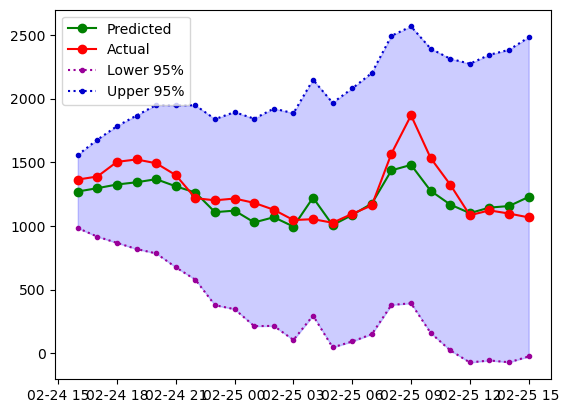

In [52]:
predicted, = plt.plot(X_test_minus_intercept[:24].index, predictions.summary_frame()['mean'], 'go-', label='Predicted')
 
actual, = plt.plot(X_test_minus_intercept[:24].index, y_test[:24], 'ro-', label='Actual')
 
lower, = plt.plot(X_test_minus_intercept[:24].index, predictions.summary_frame()['mean_ci_lower'], color='#990099', marker='.', linestyle=':', label='Lower 95%')
 
upper, = plt.plot(X_test_minus_intercept[:24].index, predictions.summary_frame()['mean_ci_upper'], color='#0000cc', marker='.', linestyle=':', label='Upper 95%')
 
plt.fill_between(X_test_minus_intercept[:24].index, predictions.summary_frame()['mean_ci_lower'], predictions.summary_frame()['mean_ci_upper'], color = 'b', alpha = 0.2)
 
plt.legend(handles=[predicted, actual, lower, upper])
 
plt.show()

# References

1. BOOK: [Time Series Analysis: Forecasting and Control, 5th Edition](https://www.wiley.com/en-us/Time+Series+Analysis:+Forecasting+and+Control,+5th+Edition-p-9781118675021)
2. BOOK: [Time Series Analysis, Regression and Forecasting with tutorials in Python](https://timeseriesreasoning.com/)
3. WEBSITE: [Introduction to Regression With ARIMA Errors Model](https://timeseriesreasoning.com/contents/regression-with-arima-errors-model/)
4. NOTES: [Summary of Multimodal Probabilistic Learning Lecture Notes by Topic](https://detraviousjbrinkley.notion.site/A-Survey-of-Multimodal-Probabilistic-Learning-for-Human-Communication-and-Emotion-Recognition-d40cab0081024276b876ae0de4204dc7) by Detravious (in construction)
5. SOFTWARE: [Calculate ACov and ACor](https://github.com/Brinkley97/book-forecasting_and_control/blob/main/part_1/2-autocorrelation_func_and_spectrum_of_stationary_process/exercises/2.4.3.ipynb) by Detravious
6. NOTES: [CH 5 Forecasting](https://detraviousjbrinkley.notion.site/CH-5-Forecasting-aa9c3fe7ad0740fbb7de9e387e3f37db) by Detravious
7. SOFTWARE: [DateTime Notes with Code from CH 12 Time Series Analysis from Pandas Cookbook](https://github.com/Brinkley97/tutorial-python_libraries/blob/main/pandas/dateTime.ipynb) by Detravious
8. SOFTWARE: [Exploring Dates and Times - Python vs Pandas Notes with Code](https://github.com/Brinkley97/tutorial-python_libraries/blob/main/pandas/dateTime2.ipynb) by Detravious 
9. NOTES: [Linear Regressions](https://detraviousjbrinkley.notion.site/Linear-Regression-aka-Numerical-8063ecf70d41418aae0057a9030941d2) by Detravious
10. SOFTWARE: [Ordinary Least Squares (OLS)](https://github.com/Brinkley97/book-forecasting_and_control/blob/main/part_1/4-linear_nonstationary_models/ordinaryLeastSquares.ipynb) by Brinkley97
11. SOFTWARE: [Lag ex 1](https://github.com/Brinkley97/book-forecasting_and_control/blob/main/part_1/2-autocorrelation_func_and_spectrum_of_stationary_process/exercises/2.4.1.ipynb) by Brinkley97 [Lag ex 2](https://github.com/Brinkley97/book-forecasting_and_control/blob/main/part_1/2-autocorrelation_func_and_spectrum_of_stationary_process/exercises/2.4.2.ipynb) by Brinkley97 [Lag ex 3](https://github.com/Brinkley97/book-forecasting_and_control/blob/main/part_1/2-autocorrelation_func_and_spectrum_of_stationary_process/exercises/2.4.3.ipynb) by Brinkley97
12. NOTES: [Additional Notes from this tutorial](https://detraviousjbrinkley.notion.site/Regression-Model-with-Seasonal-ARIMA-by-Sachin-Date-67984f7a15f9465998d77d6c375d0780) by Detravious